In [1]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import tensorflow.keras as keras
import shutil
from pandas import read_excel
import random

In [9]:
all_patients = glob.glob('/hddraid5/data/colin/covid-data/COVID Research Images/**/[0-9]*/', recursive=True)
patient_dates = {}
for patient in all_patients:
    patient = patient[:-1]
    patient_id = os.path.basename(patient)
    date = os.path.basename(os.path.dirname(patient))
    patient_dates[patient_id] = date

In [2]:
cutoff = 800000

In [3]:
base_path = '/hddraid5/data/colin/covid-data/'
label_files = glob.glob(os.path.join(base_path, '*.xlsx'))

In [4]:
orders = []
test_results = []
for label_file in label_files:
    table = read_excel(label_file)
    table_orders = list(table['Order #'])
    table_test_results = list(table['Covid Test result'])
    orders = orders + table_orders
    test_results = test_results + table_test_results

In [5]:
# lets compile a DB
positive_images = {}
negative_images = {}
for order, test_result in zip(orders, test_results):
    try:
        label = 'positive' in test_result.lower()
        np.int(order)
    except (TypeError, AttributeError):
        continue
    all_image_paths = glob.glob(os.path.join(base_path, 'COVID Research Images','**', str(order),'**', '*.jpg'), recursive=True)
    image_paths = [image_path for image_path in all_image_paths if (os.path.getsize(image_path) < cutoff and os.path.getsize(image_path) > 100)]
    if label:
        positive_images[str(order)] = image_paths
    else:
        negative_images[str(order)] = image_paths

In [18]:
positive_orders = list(positive_images.keys())
negative_orders = list(negative_images.keys())
positive_orders = [order for order in positive_orders if order in patient_dates]
negative_orders = [order for order in negative_orders if order in patient_dates]

In [19]:
positive_orders_skew = sorted(positive_orders, key=lambda x: patient_dates[x])
negative_orders_skew = sorted(negative_orders, key=lambda x: patient_dates[x])

In [20]:
positive_orders = positive_orders_skew
negative_orders = negative_orders_skew

# random.seed(1)
# random.shuffle(positive_orders)
# random.shuffle(negative_orders)

split = 0.85
pos_order_count = len(positive_orders)
neg_order_count = len(negative_orders)
positive_train_amount = int(pos_order_count*split)
negative_train_amount = int(neg_order_count*split)

train_images = []
train_labels = []
train_orders = []
train_files = []
for order in tqdm(positive_orders[:positive_train_amount]):
    images = []
    labels = []
    orders = []
    files = []
    for image_path in positive_images[order]:
        image = cv.imread(image_path)
        image = cv.resize(image, (224, 224))
        images.append(image)
        labels.append(1)
        orders.append(order)
        files.append(os.path.basename(image_path))

    train_images += images
    train_labels += labels
    train_orders += orders
    train_files  += files
for order in tqdm(negative_orders[:negative_train_amount]):
    images = []
    labels = []
    orders = []
    files = []
    for image_path in negative_images[order]:
        image = cv.imread(image_path)
        image = cv.resize(image, (224, 224))
        images.append(image)
        labels.append(0)
        orders.append(order)
        files.append(os.path.basename(image_path))
    train_images += images
    train_labels += labels
    train_orders += orders
    train_files += files
train_images = (np.array(train_images) / 255).astype(np.float32)
train_labels = np.array(train_labels)

val_images = []
val_labels = []
val_orders = []
val_files = []
for order in tqdm(positive_orders[positive_train_amount:]):
    images = []
    labels = []
    orders = []
    files = []
    for image_path in positive_images[order]:
        image = cv.imread(image_path)
        image = cv.resize(image, (224, 224))
        images.append(image)
        labels.append(1)
        orders.append(order)
        files.append(os.path.basename(image_path))

    val_images += images
    val_labels += labels
    val_orders += orders
    val_files  += files
for order in tqdm(negative_orders[negative_train_amount:]):
    images = []
    labels = []
    orders = []
    files = []
    for image_path in negative_images[order]:
        image = cv.imread(image_path)
        image = cv.resize(image, (224, 224))
        images.append(image)
        labels.append(0)
        orders.append(order)
        files.append(os.path.basename(image_path))
    val_images += images
    val_labels += labels
    val_orders += orders
    val_files  += files
val_images = (np.array(val_images) / 255).astype(np.float32)
val_labels = np.array(val_labels)

/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:58: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/colin/anaconda3/envs/covid/lib/python3.7/site-packages/ipykernel_launcher.py:75: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [21]:
def get_model(input_shape=(224,224,3), model_name='mobilenet_v2'):
    if model_name == 'mobilenet_v2':
        base_model = keras.applications.mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif model_name == 'densenet':
        base_model = keras.applications.densenet.DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    elif model_name == 'xception':
        base_model = keras.applications.xception.Xception(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    inputs = keras.Input(shape=input_shape)
    base_model.trainable = False
    x = base_model(inputs, training=False) # IMPORTANT
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256, activation='relu')(x) # just train this and following layer
    outputs = keras.layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

In [22]:
image_proc = keras.preprocessing.image.ImageDataGenerator(rotation_range=45, horizontal_flip=True, vertical_flip=True, shear_range=5)

In [23]:
means = np.mean(train_images.reshape(-1, 3), axis=0)
stds = np.std(train_images.reshape(-1, 3), axis=0)

In [24]:
train_x = (train_images - means) / stds
train_y = keras.utils.to_categorical(train_labels)
val_x = (val_images - means) / stds
val_y = keras.utils.to_categorical(val_labels)

In [25]:
train_chance = np.sum(train_labels)/len(train_labels)
val_chance = np.sum(val_labels)/len(val_labels)

In [26]:
model = get_model(model_name='densenet')
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
callbacks = keras.callbacks.ModelCheckpoint('densenet_covid_seed_skew.hdf5')
batch_size = 16
model.fit(image_proc.flow(train_x, train_y, batch_size=batch_size),
                    steps_per_epoch=len(train_x) / batch_size, epochs=40, validation_data=(val_x, val_y), shuffle=False, callbacks=[callbacks])

  ...
    to  
  ['...']
Train for 1169.125 steps, validate on 3541 samples
Epoch 1/40
1170/1169 [==============================] - 219s 187ms/step - loss: 0.5403 - accuracy: 0.7309 - val_loss: 0.6479 - val_accuracy: 0.6498
Epoch 2/40
1170/1169 [==============================] - 204s 174ms/step - loss: 0.4827 - accuracy: 0.7693 - val_loss: 0.6567 - val_accuracy: 0.6651
Epoch 3/40
1170/1169 [==============================] - 213s 182ms/step - loss: 0.4515 - accuracy: 0.7856 - val_loss: 0.6563 - val_accuracy: 0.6586
Epoch 4/40
1170/1169 [==============================] - 212s 181ms/step - loss: 0.4296 - accuracy: 0.7997 - val_loss: 0.6818 - val_accuracy: 0.6662
Epoch 5/40
1170/1169 [==============================] - 215s 183ms/step - loss: 0.4148 - accuracy: 0.8062 - val_loss: 0.6563 - val_accuracy: 0.6752
Epoch 6/40
1170/1169 [==============================] - 203s 174ms/step - loss: 0.4088 - accuracy: 0.8129 - val_loss: 0.7122 - val_accuracy: 0.6637
Epoch 7/40
1170/1169 [==============

In [27]:
saved_model = keras.models.load_model('densenet_covid_seed_skew.hdf5')
labels = saved_model.predict(val_x)

In [28]:
results = {
}

for order, label, gt, file in zip(val_orders, labels, val_labels, val_files):
    if order in results:
        results[order]['labels'].append(float(label[1]))
        results[order]['files'].append(file)
    else:
        if gt == 1:
            test = True
        else:
            test = False
        results[order] = {
            'test_result': test,
            'labels': [float(label[1])],
            'files': [file]
        }

In [29]:
import json

In [30]:
with open('val_results_v1_skew.json', 'w') as fp:
    json.dump(results, fp)

In [36]:
results

{'10049324995': {'test_result': True,
  'labels': [0.65376407,
   0.98613435,
   0.70638686,
   0.7906331,
   0.9634966,
   0.8578785,
   0.8815926,
   0.9017688,
   0.9862054,
   0.78786707,
   0.8265196,
   0.94190913,
   0.86752045,
   0.7251263,
   0.9751031,
   0.9924425,
   0.99326503,
   0.7256244,
   0.81116843,
   0.9693601,
   0.8106483,
   0.9628231,
   0.9529539,
   0.82448816,
   0.53408486,
   0.60345685,
   0.43508825,
   0.73806185,
   0.92094034,
   0.84565556,
   0.9894482,
   0.7243337,
   0.9512659,
   0.8883543,
   0.6385412,
   0.8921681,
   0.9169376,
   0.7429376,
   0.89966106,
   0.95371705,
   0.9720785,
   0.99868006,
   0.9653386,
   0.8954052,
   0.9861238,
   0.65695435,
   0.9421929,
   0.9544694,
   0.36589485,
   0.92776346,
   0.81352395,
   0.680466,
   0.92924225,
   0.9910618,
   0.9901663,
   0.8067475,
   0.6399946,
   0.87064946,
   0.8011198,
   0.57964134,
   0.87598735,
   0.8992775,
   0.99818784,
   0.9572294,
   0.94007564,
   0.9520584,
 

In [38]:
with open("val_results_v1.csv", 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Patient ID', 'COVID Test Result', 'Predicted Results'])
    for order in results.keys():
        data = [order] + results[order]
        writer.writerow(data)
        data2 = 

In [30]:
val_labels

array([1, 1, 1, ..., 0, 0, 0])

In [33]:
results = {
}

for order, label, gt in zip(val_orders, labels, val_labels):
    if order in results:
        results[order].append(label[1])
    else:
        if gt == 1:
            test = True
        else:
            test = False
        results[order] = [test, label[1]]

In [29]:
import csv

In [34]:
with open("val_results.csv", 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['Patient ID', 'COVID Test Result', 'Predicted Results'])
    for order in results.keys():
        data = [order] + results[order]
        writer.writerow(data)

In [28]:
results

{'10049366433': [0.76882756,
  0.5452392,
  0.8946087,
  0.26226738,
  0.8485111,
  0.7301781,
  0.7359045,
  0.61163956,
  0.9419013,
  0.37157843,
  0.6793832,
  0.54168785,
  0.43366197,
  0.8867539,
  0.37454998,
  0.4669679,
  0.37847462,
  0.75051767,
  0.8748262,
  0.5100822,
  0.8582762,
  0.17782463,
  0.75162345,
  0.5895186,
  0.70990473,
  0.9281302,
  0.4034225,
  0.79617417,
  0.2983429,
  0.3710604,
  0.8013927,
  0.8628644,
  0.61454535,
  0.7946255,
  0.5449573,
  0.6167803,
  0.49756366,
  0.49613166,
  0.88387764,
  0.9176125,
  0.63254565,
  0.8929475,
  0.94390094,
  0.8636342,
  0.5777564,
  0.5075518,
  0.8646915,
  0.856119,
  0.49882725,
  0.90205914,
  0.7010599,
  0.9077302,
  0.2742001,
  0.6623394,
  0.5577388,
  0.9602585,
  0.80014163,
  0.8102898,
  0.78513217,
  0.20597585,
  0.8794685,
  0.9232356,
  0.7884653,
  0.7829721,
  0.2662483,
  0.9870718,
  0.89475316,
  0.59751886,
  0.67754126,
  0.9125785,
  0.49384966,
  0.77834016,
  0.55481946,
  0.728

In [24]:
zip(val_orders, labels)

In [22]:
val_orders

['10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '10049366433',
 '100493

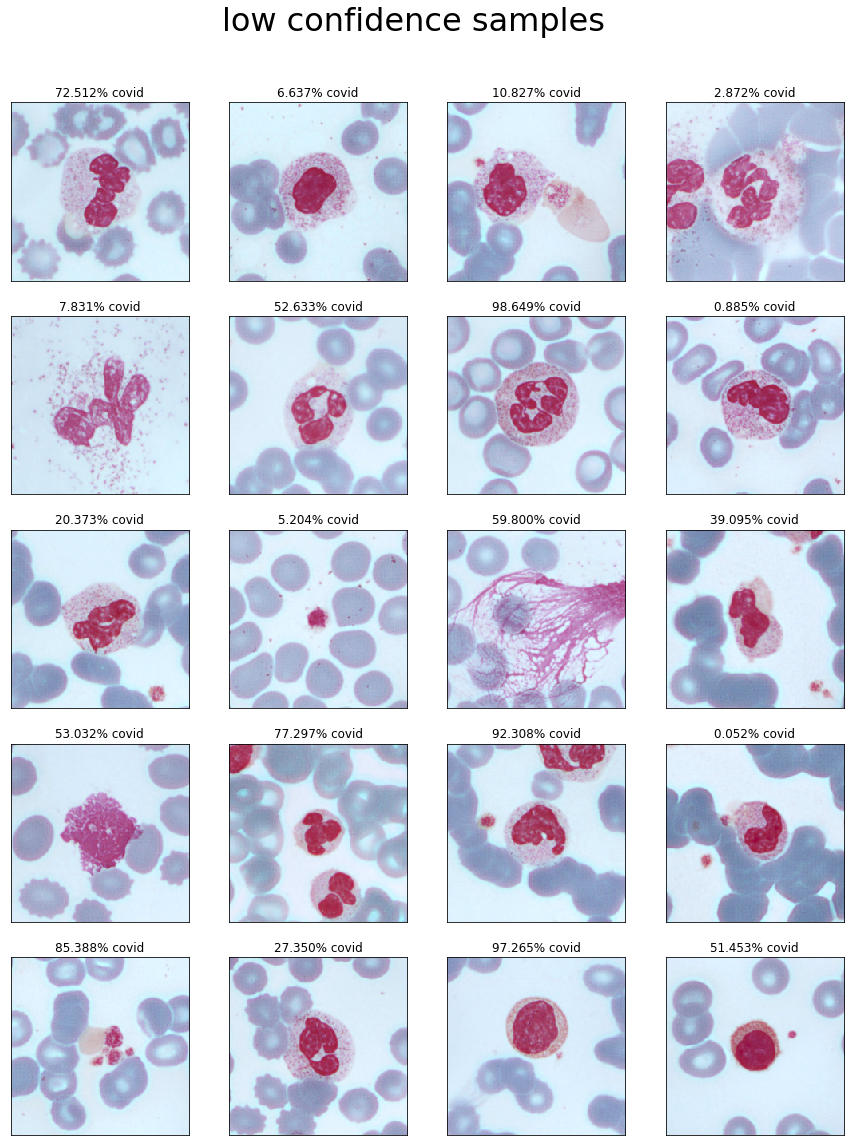

In [98]:
indices = np.arange(0, len(labels))
display_indices = np.random.choice(indices, size=5*4, replace=False)
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(15,19))
fig.suptitle("low confidence samples", fontsize=32, y=0.95)
for i in range(5):
    for j in range(4):
        ind = display_indices[i*4 + j]
        axs[i,j].imshow(val_images[ind])
        label = f'{100*labels[ind][0]:.3f}% covid'
        axs[i,j].set_title(label)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])